In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train= pd.read_csv("../input/train.csv", na_values=-1)
test = pd.read_csv('../input/test.csv', na_values=-1)

In [3]:
for c in train.select_dtypes(include=['float64']).columns:
    train[c]=train[c].astype(np.float16)
    test[c]=test[c].astype(np.float16)
for c in train.select_dtypes(include=['int64']).columns[2:]:
    train[c]=train[c].astype(np.int8)
    test[c]=test[c].astype(np.int8)    

In [4]:
positive_size = train[train.target==1].shape[0]

In [5]:
positive_percentage = positive_size/float(train.shape[0])

In [6]:
print("%.2f" % (positive_percentage*100), "% of the data is labelled as positive.")

3.64 % of the data is labelled as positive.


## Missing values

In [6]:
missing_values = train.apply(lambda x: sum(x.isnull())/float(len(x)), axis=0)

In [10]:
print("Top 5 Features with most missing values and the percentage:")
print(missing_values.sort_values(ascending=False).head(10))

Top 5 Features with most missing values and the percentage:
ps_car_03_cat    0.690898
ps_car_05_cat    0.447825
ps_reg_03        0.181065
ps_car_14        0.071605
ps_car_07_cat    0.019302
ps_ind_05_cat    0.009760
ps_car_09_cat    0.000956
ps_ind_02_cat    0.000363
ps_car_01_cat    0.000180
ps_ind_04_cat    0.000139
dtype: float64


In [7]:
train = train.drop(['ps_car_03_cat', 'ps_car_05_cat','id'], axis=1)

## Visualisation

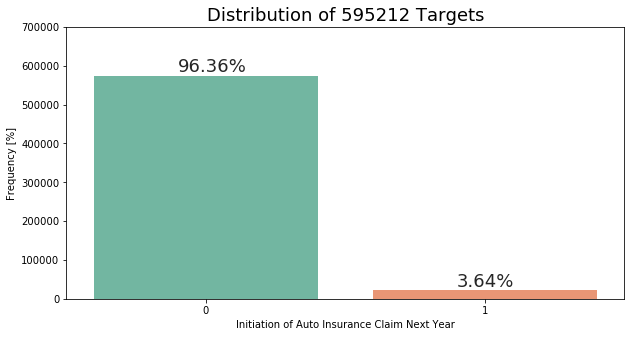

In [12]:
ax = sns.countplot(x = train.target.values ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=700000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 595212 Targets')
plt.xlabel('Initiation of Auto Insurance Claim Next Year')
plt.ylabel('Frequency [%]')
plt.show()

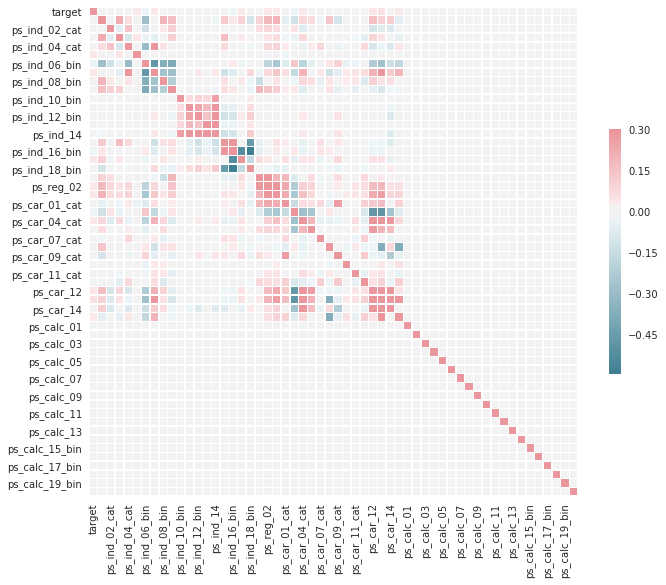

In [13]:
sns.set(style="white")

# Compute the correlation matrix
corr = train.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [14]:
abs(corr.target).sort_values()

ps_calc_04        0.000033
ps_calc_06        0.000082
ps_calc_07        0.000103
ps_calc_17_bin    0.000170
ps_calc_11        0.000371
ps_calc_13        0.000446
ps_calc_15_bin    0.000490
ps_calc_18_bin    0.000552
ps_calc_16_bin    0.000624
ps_calc_09        0.000719
ps_calc_05        0.000771
ps_calc_08        0.001006
ps_car_10_cat     0.001038
ps_calc_10        0.001061
ps_calc_20_bin    0.001072
ps_calc_12        0.001133
ps_car_11         0.001220
ps_calc_02        0.001360
ps_calc_14        0.001362
ps_calc_19_bin    0.001744
ps_calc_01        0.001782
ps_ind_10_bin     0.001815
ps_calc_03        0.001907
ps_ind_11_bin     0.002028
ps_ind_13_bin     0.002460
ps_ind_18_bin     0.004555
ps_ind_02_cat     0.005574
ps_car_09_cat     0.006013
ps_car_11_cat     0.006129
ps_ind_14         0.007443
ps_ind_12_bin     0.007810
ps_ind_09_bin     0.008237
ps_ind_03         0.008360
ps_ind_04_cat     0.010146
ps_car_06_cat     0.011537
ps_car_14         0.011674
ps_ind_08_bin     0.013147
p

## Define Gini metric

In [8]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

## Model training

In [9]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=0)

In [11]:
X = train.drop(['target'], axis=1).values
y = train.target.values
features = train.drop(['target'], axis=1).columns

In [12]:
sub=test['id'].to_frame()
sub['target']=0

In [13]:
params = {
    'eval_metric': 'auc',
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

In [14]:
import gc

In [47]:
for i, (train_indices, test_indices) in enumerate(skf.split(X, y)):
    print(test_indices[20:30])

[ 98 100 102 103 104 113 116 123 125 127]
[149 151 161 162 164 172 174 188 189 193]
[ 75  76  77  80  84 105 124 130 133 135]
[109 110 111 112 115 120 126 129 138 142]
[118 119 121 122 128 131 137 139 140 146]


In [15]:
for i, (train_indices, test_indices) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    d_train = xgb.DMatrix(X_train, y_train)
    d_test = xgb.DMatrix(X_test, y_test)
    watchlist = [(d_train, 'train'), (d_test, 'valid')]
    xgb_model = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, 
                    feval=gini_xgb, maximize=True, verbose_eval=100)
    sub['target'] += xgb_model.predict(xgb.DMatrix(test[features].values), 
                        ntree_limit=xgb_model.best_ntree_limit+50) / kfold
    print('Fold %d out of %d training completed.' % (i + 1, kfold))
    gc.collect()

[0]	train-gini:0.076973	valid-gini:0.072039
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-gini:0.328426	valid-gini:0.267852
[200]	train-gini:0.375537	valid-gini:0.275137
[300]	train-gini:0.420937	valid-gini:0.281523
[400]	train-gini:0.459539	valid-gini:0.281674
Stopping. Best iteration:
[412]	train-gini:0.463861	valid-gini:0.281933

Fold 1 out of 5 training completed.
[0]	train-gini:0.029758	valid-gini:0.021382
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-gini:0.325626	valid-gini:0.277032
[200]	train-gini:0.37518	valid-gini:0.285863
[300]	train-gini:0.419024	valid-gini:0.29024
[400]	train-gini:0.454356	valid-gini:0.29026
Stopping. Best iteration:
[337]	train-gini:0.431733	valid-gini:0.290666

Fold 2 out of 5 training completed.
[0]	train-gini:0.019029	valid-gini:0.02

In [16]:
sub

,id,target
0,0,0.029752
1,1,0.026077
2,2,0.027077
3,3,0.015537
4,4,0.035939
5,5,0.037213
6,6,0.017019
7,8,0.034861
8,10,0.050004
9,11,0.051318


In [17]:
sub.to_csv('submit_result.csv', index=None)